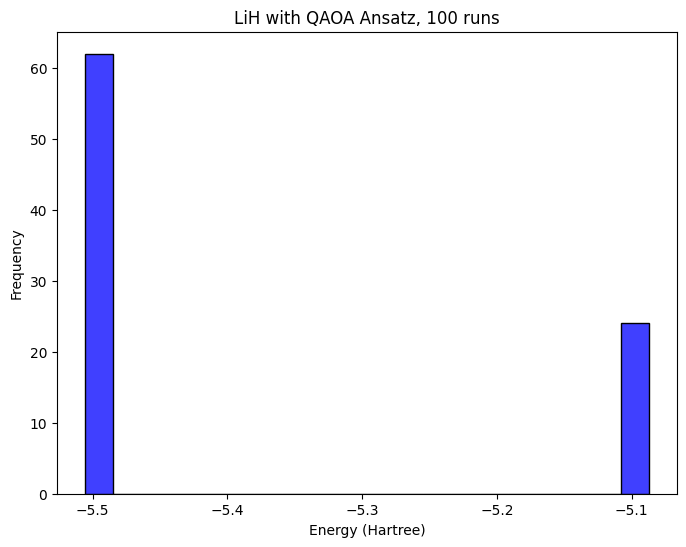

Lowest energy achieved: -5.505684 Hartree


In [5]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.primitives import Estimator
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
import numpy as np
from scipy.optimize import minimize
import networkx as nx
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
import seaborn as sns

# Function to get the molecule Hamiltonian
def get_molecule_hamiltonian(driver):
    es_problem = driver.run()
    second_q_op = es_problem.second_q_ops()[0]
    mapper = JordanWignerMapper()
    qubit_hamiltonian = mapper.map(second_q_op)
    return qubit_hamiltonian

# QAOA ansatz with all-to-all connectivity
def qaoa_ansatz(num_qubits, p):
    graph = nx.complete_graph(num_qubits)  # All-to-all connectivity

    qc = QuantumCircuit(num_qubits)
    beta = [Parameter(f'\u03B2{i}') for i in range(p)]
    gamma = [Parameter(f'\u03B3{i}') for i in range(p)]

    qc.h(range(num_qubits))
    for i in range(p):
        for u, v in graph.edges:
            qc.rzz(2 * gamma[i], u, v)
        qc.rx(2 * beta[i], range(num_qubits))

    return qc, beta + gamma

# Cost function
def cost_function(params, hamiltonian, num_qubits):
    p = len(params) // 2
    qc, param_vec = qaoa_ansatz(num_qubits, p)
    param_dict = {param_vec[i]: params[i] for i in range(len(param_vec))}
    bound_circuit = qc.assign_parameters(param_dict)

    estimator = Estimator()
    result = estimator.run(bound_circuit, [hamiltonian])
    return result.result().values[0]

# Optimization loop with timeout
def optimization_loop_with_timeout(hamiltonian, num_qubits, optimizer, initial_params, timeout=30):
    start_time = time.time()

    def cost(params):
        return cost_function(params, hamiltonian, num_qubits)

    result = None
    try:
        result = minimize(
            cost,
            initial_params,
            method=optimizer,
            options={'maxiter': 500, 'tol': 1e-6},
            callback=lambda xk: (time.time() - start_time) < timeout,
        )
    except Exception as e:
        print(f"Optimization failed: {e}")

    if result and result.success:
        return result.fun, result.x
    else:
        return None, None

# Parallel optimization runs
def run_multiple_optimizations_parallel(num_runs, hamiltonian, num_qubits, optimizer, p, timeout=30):
    energies = []
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(
                optimization_loop_with_timeout,
                hamiltonian,
                num_qubits,
                optimizer,
                np.random.uniform(0, 2 * np.pi, 2 * p),
                timeout,
            )
            for _ in range(num_runs)
        ]

        for future in as_completed(futures):
            optimal_value, _ = future.result()
            if optimal_value is not None:
                # Only append successfully optimized energies
                energies.append(optimal_value)

    return energies

# Driver definition
driver = PySCFDriver(
    atom="Li 0 0 0; H 0 0 1.5949",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

# Get Hamiltonian and number of qubits
qubit_hamiltonian = get_molecule_hamiltonian(driver)
num_qubits = qubit_hamiltonian.num_qubits

# Define optimizer and QAOA layers
optimizer = 'COBYLA'
p = 1  # Number of QAOA layers

# Perform parallel optimization
num_runs = 100  # Adjust the number of runs as needed
timeout = 30  # Limit each optimization to 30 seconds

energies = run_multiple_optimizations_parallel(num_runs, qubit_hamiltonian, num_qubits, optimizer, p, timeout)

# Plot results
plt.figure(figsize=(8, 6))
sns.histplot(energies, kde=False, bins=20, color='blue')
plt.title('LiH with QAOA Ansatz, 100 runs')
plt.xlabel('Energy (Hartree)')
plt.ylabel('Frequency')
plt.show()

# Print the best energy achieved
if energies:
    print(f'Lowest energy achieved: {min(energies):.6f} Hartree')
else:
    print("No successful optimizations.")
